<a href="https://colab.research.google.com/github/Arden-Zhu/fashion_net2/blob/master/A_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 1

In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io

In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
my_drive_dir = "/content/gdrive/My Drive/Machine Learning"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## prepare images

In [18]:
since = time.time()
data_source_dir = os.path.join(my_drive_dir, 'Datasets\DeepFashion\Category and Attribute Prediction Benchmark'.replace('\\', '/'))
tar_file = os.path.join(data_source_dir, 'picked.tar')
if not os.path.exists('data'):
  os.mkdir('data')
! tar xf "{tar_file}" -C data/
print('%.3f' % (time.time() - since))

3.823


In [20]:
csv_file = os.path.join(data_source_dir, 'picked.csv')
df = pd.read_csv(csv_file, index_col=0)
df = df.loc[:, ['file', 'category_name', 'category_id']]
df['file'] = df.apply(lambda m: m.file[4:], axis=1)
df.head()

,file,category_name,category_id
23063,Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg,Blouse,3
30780,Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg,Blouse,3
13998,Crochet_Lace-Paneled_Blouse/img_00000035.jpg,Blouse,3
123023,New_York_City_Pocket_Tee/img_00000012.jpg,Tee,18
21889,Georgette_Tulip_Back_Blouse/img_00000029.jpg,Blouse,3


In [46]:
df2 = df.head(3)
df2.columns=['file', 'type', 'label']
df2['type'] = ['train', 'test', 'train']
df2['label'] = ['a', 'b', 'c']
df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,file,type,label
23063,Kimono-Sleeved_Paisley_Blouse/img_00000121.jpg,train,a
30780,Boxy_Chiffon_Pocket_Blouse/img_00000056.jpg,test,b
13998,Crochet_Lace-Paneled_Blouse/img_00000035.jpg,train,c


## load data

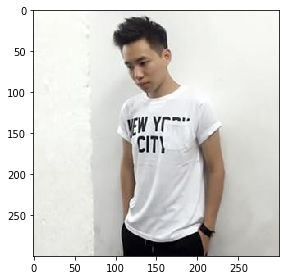

In [32]:
class ImageDataset(Dataset):
  '''
  a dataset provides (image, label)
  '''
  def __init__(self, path:str, image_files, labels, transform=None):
    self.path = path
    self.image_files = image_files
    self.labels = labels
    self.transform = transform
    assert(len(image_files) == len(labels))

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, idx):
    file = os.path.join(self.path, self.image_files[idx])
    image = io.imread(file)
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return (image, label)

##############################
image_ds = ImageDataset('data/data/picked', ['New_York_City_Pocket_Tee/img_00000012.jpg'], ['Tee'])
assert(len(image_ds) == 1)
(image, label) = image_ds[0]
assert(label == 'Tee')    
io.imshow(image)
plt.show()

In [49]:
class DataSource():
  '''
  train_dl
  test_dl
  train_ds
  test_dl
  '''
  def __init__(self, path:str, df:pd.DataFrame, bs:int, transform=None, 
               num_workers=0):
      '''
      path : path of images
      df : DataFrame with file, label, type
      '''
      is_train = df.type == 'train'
      self.train_ds = ImageDataset(path, df[is_train]['file'].values, df[is_train]['label'].values, transform)
      self.test_ds = ImageDataset(path, df[~is_train]['file'].values, df[~is_train]['label'].values, transform)

      self.train_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=True, 
                                 num_workers=num_workers)
      
      self.test_dl = DataLoader(self.train_ds, batch_size=bs, shuffle=False, 
                                 num_workers=num_workers)

############################################################################
ds = DataSource('data/data/picked', df2, 2)
assert(len(ds.train_ds) == 2)
assert(len(ds.test_ds) == 1)
assert(ds.test_ds[0][1] == 'b')

for (image, label) in ds.train_dl:
  print(label)

('a', 'c')
